## **GPT-1 pytorch로 구현하기**
- 링크 : [참고 블로그](https://m.blog.naver.com/PostView.naver?blogId=rbdus0715&logNo=223393183483&proxyReferer=https:%2F%2Fwww.google.com%2F&trackingCode=external)
- 깃허브 : [주소](https://github.com/lyeoni/gpt-pytorch)
- 트랜스포머 디코더 기반 모델로 기존 트랜스포머 구현 거의 동일하게 따라감.

### Install dependencies

In [2]:
! pip install prenlp
! git clone https://github.com/LiyuanLucasLiu/RAdam
! python RAdam/setup.py install

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 34.8 MB/s eta 0:00:00
  Created wheel for nltk: filename=nltk-3.2.5-py3-none-any.whl size=1392144 sha256=447821fcbb9a3ae382ae961c1b1e0604e5d4d52307ea7e4ec612ea005ca4ec6c
  Stored in directory: /root/.cache/pip/wheels/0e/69/e3/8b11e6490c8f20fcab5f6a3321d60fcc0b26ed6f7745ad95b4
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.9.1
    Uninstalling nltk-3.9.1:
      Successfully uninstalled nltk-3.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of

### data_utils(데이터셋)

In [1]:
from typing import Iterable, Union, List
from pathlib import Path
import json

import torch
import torch.distributed as dist
from torch.utils.data import TensorDataset

class PretrainInputExample:
    """A single example for unsupervised pre-training.
    """
    def __init__(self, text: str):
        self.text = text

class ClsInputExample:
    """A single example for supervised fine-tuning (classification).
    """
    def __init__(self, text: str, label: str):
        self.text = text
        self.label = label

class PretrainInputFeatures:
    """A single set of features of pre-training data.
    """
    def __init__(self, input_ids: List[int]):
        self.input_ids = input_ids

class ClsInputFeatures:
    """A single set of features of fine-tuning data (classification).
    """
    def __init__(self, input_ids: List[int], label_id: int):
        self.input_ids = input_ids
        self.label_id = label_id

def convert_examples_to_features(examples,
                                 tokenizer,
                                 args,
                                 mode):
    bos_token = tokenizer.bos_token
    eos_token = tokenizer.eos_token
    pad_token = tokenizer.pad_token

    # Build label dict(vocab) with examples
    if args.finetune:
        if mode == 'train':
            labels = sorted(list(set([example.label for example in examples])))
            label_dict = {label: i for i, label in enumerate(labels)}
            with open(args.cached_label_dict, 'w') as file:
                json.dump(label_dict, file,  indent=4)
        elif mode == 'test':
            with open(args.cached_label_dict, 'r') as file:
                label_dict = json.load(file)

    # Create features
    features = []
    for i, example in enumerate(examples):
        tokens = tokenizer.tokenize(example.text)
        tokens = [bos_token] + tokens[:args.max_seq_len-2] + [eos_token] # BOS, EOS
        tokens += [pad_token] * (args.max_seq_len - len(tokens))

        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        if args.finetune:
            label_id = label_dict.get(example.label)

        if args.pretrain:
            feature = PretrainInputFeatures(input_ids)
        elif args.finetune:
            feature = ClsInputFeatures(input_ids, label_id)

        features.append(feature)

    return features

def create_examples(args, tokenizer, mode='train'):
    if args.local_rank not in [-1, 0]: # Make sure only the first process in distributed training process the dataset, and the others will use the cache
        dist.barrier()

    # Load data features from cache or dataset file
    assert mode in ('train', 'test')
    cached_features_file = Path('cached_features_{}_{}_{}'.format('pretrain' if args.pretrain else 'finetune', mode, args.max_seq_len))

    if cached_features_file.exists():
        print('Loading features from cached file', cached_features_file)
        features = torch.load(cached_features_file)
    else:
        corpus_path = args.train_corpus if mode=='train' else args.test_corpus
        with open(corpus_path, 'r', encoding='utf-8') as reader:
            corpus = reader.readlines()

        # Create examples
        if args.pretrain:
            corpus = list(map(lambda x: x.strip(), corpus))
            corpus = list(filter(lambda x: len(x) > 0, corpus))
            examples = [PretrainInputExample(text) for text in corpus]
        elif args.finetune:
            corpus = list(map(lambda x: x.split('\t'), corpus))
            corpus = list(map(lambda x: list(map(lambda y: y.strip(), x)), corpus))
            corpus = list(map(lambda x: list(filter(lambda y: len(y) > 0, x)), corpus))
            examples = [ClsInputExample(text, label) for label, text in corpus]

        # Convert examples to features
        features = convert_examples_to_features(examples, tokenizer, args, mode)

        print('Saving features into cached file', cached_features_file)
        torch.save(features, cached_features_file)

    if args.local_rank == 0: # Make sure only the first process in distributed training process the dataset, and the others will use the cache
        dist.barrier()

    # Create dataset with features
    if args.pretrain:
        all_input_ids = torch.tensor([feature.input_ids for feature in features], dtype=torch.long)
        dataset = TensorDataset(all_input_ids)
    elif args.finetune:
        all_input_ids = torch.tensor([feature.input_ids for feature in features], dtype=torch.long)
        all_label_ids = torch.tensor([feature.label_id for feature in features], dtype=torch.long)
        dataset = TensorDataset(all_input_ids, all_label_ids)

    return dataset

### tokenization(토큰화)

In [8]:
"""Code from
    - https://github.com/lyeoni/nlp-tutorial/blob/master/translation-transformer/tokenization.py
    - https://github.com/lyeoni/nlp-tutorial/blob/master/text-classification-transformer/tokenization.py
"""
from typing import List
from collections import OrderedDict

from prenlp.tokenizer import SentencePiece

class Tokenizer:
    def __init__(self, tokenizer, vocab_file: str,
                 pad_token: str = '[PAD]',
                 unk_token: str = '[UNK]',
                 bos_token: str = '[BOS]',
                 eos_token: str = '[EOS]',
                 sep_token: str = '[SEP]',
                 cls_token: str = '[CLS]',
                 mask_token: str = '[MASK]'):
        self.tokenizer = tokenizer
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.bos_token = bos_token
        self.eos_token = eos_token
        self.sep_token = sep_token
        self.cls_token = cls_token
        self.mask_token = mask_token
        self.vocab = OrderedDict()
        self.ids_to_tokens = OrderedDict()

        # Build vocab and ids_to_tokens
        with open(vocab_file, 'r', encoding='utf-8') as reader:
            for i, line in enumerate(reader.readlines()):
                token = line.split()[0]
                self.vocab[token] = i
        for token, id in self.vocab.items():
            self.ids_to_tokens[id] = token

    def tokenize(self, text: str) -> List[str]:
        """Tokenize given text.
        """
        return self.tokenizer(text)

    def convert_token_to_id(self, token: str) -> int:
        """Convert a token (str) in an id (integer) using the vocab.
        """
        return self.vocab.get(token, self.vocab.get(self.unk_token))

    def convert_id_to_token(self, id: int) -> str:
        """Convert an id (integer) in a token (str) using the vocab.
        """
        return self.ids_to_tokens.get(id, self.unk_token)

    def convert_tokens_to_ids(self, tokens: List[str]) -> List[int]:
        """Convert list of tokens in list of ids using the vocab.
        """
        return [self.convert_token_to_id(token) for token in tokens]

    def convert_ids_to_tokens(self, ids: List[int]) -> List[str]:
        """Convert list of ids in list of tokens using the vocab.
        """
        return [self.convert_id_to_token(id) for id in ids]

    @property
    def vocab_size(self) -> int:
        """Vocabulary size.
        """
        return len(self.vocab)

    @property
    def pad_token_id(self) -> int:
        """Id of pad_token in the vocab.
        """
        return self.convert_token_to_id(self.pad_token)

    @property
    def unk_token_id(self) -> int:
        """Id of unk_token in the vocab.
        """
        return self.convert_token_to_id(self.unk_token)

    @property
    def bos_token_id(self) -> int:
        """Id of bos_token in the vocab.
        """
        return self.convert_token_to_id(self.bos_token)

    @property
    def eos_token_id(self) -> int:
        """Id of eos_token in the vocab.
        """
        return self.convert_token_to_id(self.eos_token)

    @property
    def sep_token_id(self) -> int:
        """Id of sep_token in the vocab.
        """
        return self.convert_token_to_id(self.sep_token)

    @property
    def cls_token_id(self) -> int:
        """Id of cls_token in the vocab.
        """
        return self.convert_token_to_id(self.cls_token)

    @property
    def mask_token_id(self) -> int:
        """Id of mask_token in the vocab.
        """
        return self.convert_token_to_id(self.mask_token)

class PretrainedTokenizer(Tokenizer):
    def __init__(self, pretrained_model: str, vocab_file: str,
                 pad_token: str = '[PAD]',
                 unk_token: str = '[UNK]',
                 bos_token: str = '[BOS]',
                 eos_token: str = '[EOS]',
                 sep_token: str = '[SEP]',
                 cls_token: str = '[CLS]',
                 mask_token: str = '[MASK]'):
        tokenizer = SentencePiece.load(pretrained_model)

        super(PretrainedTokenizer, self).__init__(tokenizer, vocab_file, pad_token, unk_token, bos_token, eos_token)

    def detokenize(self, tokens: List[str]) -> str:
        """Detokenize given tokens.
        """
        return self.tokenizer.detokenize(tokens)

### 모델 구축(model.py)



In [3]:
import torch
import torch.nn as nn

In [4]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, attn_pdrop):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k

        self.dropout = nn.Dropout(attn_pdrop)

    def forward(self, q, k, v, attn_mask):
        # |q| : (batch_size, n_heads, q_len, d_k)
        # |k| : (batch_size, n_heads, k_len, d_k)
        # |v| : (batch_size, n_heads, v_len, d_v)
        # |attn_mask| : (batch_size, n_heads, q_len, k_len)

        attn_score = torch.matmul(q, k.transpose(-1, -2)) / (self.d_k ** 0.5)
        attn_score.masked_fill_(attn_mask, -1e9)
        # |attn_score| : (batch_size, n_heads, q_len, k_len)

        attn_weights = nn.Softmax(dim=-1)(attn_score)
        attn_weights = self.dropout(attn_weights)
        # |attn_weights| : (batch_size, n_heads, q_len, k_len)

        output = torch.matmul(attn_weights, v)
        # |output| : (batch_size, n_heads, q_len, d_v)

        return output, attn_weights


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, attn_pdrop):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_k = self.d_v = d_model // n_heads

        self.WQ = nn.Linear(d_model, d_model)
        self.WK = nn.Linear(d_model, d_model)
        self.WV = nn.Linear(d_model, d_model)
        self.scaled_dot_product_attn = ScaledDotProductAttention(self.d_k, attn_pdrop)
        self.linear = nn.Linear(n_heads * self.d_v, d_model)

    def forward(self, Q, K, V, attn_mask):
        # |Q| : (batch_size, q_len(=seq_len), d_model)
        # |K| : (batch_size, k_len(=seq_len), d_model)
        # |V| : (batch_size, v_len(=seq_len), d_model)
        # |attn_mask| : (batch_size, q_len, k_len)
        batch_size = Q.size(0)

        q_heads = self.WQ(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        k_heads = self.WK(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        v_heads = self.WV(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1, 2)
        # |q_heads| : (batch_size, n_heads, q_len, d_k)
        # |k_heads| : (batch_size, n_heads, k_len, d_k)
        # |v_heads| : (batch_size, n_heads, v_len, d_v)

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1)
        # |attn_mask| : (batch_size, n_heads, q_len, k_len)
        attn, attn_weights = self.scaled_dot_product_attn(q_heads, k_heads, v_heads, attn_mask)
        # |attn| : (batch_size, n_heads, q_len, d_v)
        # |attn_weights| : (batch_size, n_heads, q_len, k_len)

        attn = attn.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v)
        # |attn| : (batch_size, q_len, n_heads * d_v)
        outputs = self.linear(attn)
        # |outputs| : (batch_size, q_len, d_model)

        return outputs, attn_weights


class PositionWiseFeedForwardNetwork(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForwardNetwork, self).__init__()

        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.gelu = nn.GELU()

        nn.init.normal_(self.linear1.weight, std=0.02)
        nn.init.normal_(self.linear2.weight, std=0.02)

    def forward(self, inputs):
        # |inputs| : (batch_size, seq_len, d_model)

        outputs = self.gelu(self.linear1(inputs))
        # |outputs| : (batch_size, seq_len, d_ff)
        outputs = self.linear2(outputs)
        # |outputs| : (batch_size, seq_len, d_model)

        return outputs


class DecoderLayer(nn.Module):
    def _init__(self, d_model, n_heads, d_ff, attn_pdrop, resid_pdrop):
        super(DecoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, n_heads, attn_pdrop)
        self.dropout1 = nn.Dropout(resid_pdrop)
        self.layernorm1 = nn.LayerNorm(d_model, eps=1e-5)

        self.ffn = PositionWiseFeedForwardNetwork(d_model, d_ff)
        self.dropout2 = nn.Dropout(resid_pdrop)
        self.layernorm2 = nn.LayerNorm(d_model, eps=1e-5)

    ## 입력이 전처리를 거치고, masked 멀티헤드어텐션, 층정규화, feedforward층, 다시 층정규화 거침 ##
    ## 중간 중간 잔차 연결 존재 ##
    def forward(self, inputs, attn_mask):
        # |inputs| : (batch_size, seq_len, d_model)
        # |attn_mask| : (batch_size, seq_len, seq_len)

        attn_outputs, attn_weights = self.mha(inputs, inputs, inputs, attn_mask)
        attn_outputs = self.dropout1(attn_outputs)
        attn_outputs = self.layernorm1(inputs + attn_outputs)
        # |attn_outputs| : (batch_size, seq_len, d_model)
        # |attn_weights| : (batch_size, n_heads, q_len(=seq_len), k_len(=seq_len))

        ffn_outputs = self.ffn(attn_outputs)
        ffn_outputs = self.dropout2(ffn_outputs)
        ffn_outputs = self.layernorm2(attn_outputs + ffn_outputs)  # 잔차 연결
        # |ffn_outputs| : (batch_size, seq_len, d_model)

        return ffn_outputs, attn_weights


class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, seq_len, d_model, n_layers, n_heads, d_ff, embd_pdrop, attn_pdrop, resid_pdrop, pad_id):
        super(TransformerDecoder, self).__init__()
        self.pad_id = pad_id

        # layers
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.dropout = nn.Dropout(embd_pdrop)
        self.pos_embedding = nn.Embedding(seq_len+1, d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, attn_pdrop, resid_pdrop) for _ in range(n_layers)])

        nn.init.normal_(self.embedding.weight, std=0.02)

    def forward(self, inputs):
        # |inputs| : (batch_size, seq_len)
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).repeat(inputs.size(0), 1)+1
        position_pad_mask = inputs.eq(self.pad_id)
        positions.masked_fill_(position_pad_mask, 0)
        # |positions| : (batch_size, seq_len)

        ## 포지션 임베딩 값 더해주는 과정 ##
        outputs = self.dropout(self.embedding(inputs)) + self.pos_embedding(positions)
        # |outputs| : (batch_size, seq_len, d_model)

        attn_pad_mask = self.get_attention_padding_mask(inputs, inputs, self.pad_id)
        # |attn_pad_mask| : (batch_size, seq_len, seq_len)
        subsequent_mask = self.get_attention_subsequent_mask(inputs).to(device=attn_pad_mask.device)
        # |subsequent_mask| : (batch_size, seq_len, seq_len)
        attn_mask = torch.gt((attn_pad_mask.to(dtype=subsequent_mask.dtype) + subsequent_mask), 0)
        # |attn_mask| : (batch_size, seq_len, seq_len)

        ## 디코더 레이어를 n번 통과한 결과 계산 ##
        attention_weights = []
        for layer in self.layers:
            outputs, attn_weights = layer(outputs, attn_mask)
            # |outputs| : (batch_size, seq_len, d_model)
            # |attn_weights| : (batch_size, n_heads, seq_len, seq_len)
            attention_weights.append(attn_weights)

        return outputs, attention_weights

    def get_attention_padding_mask(self, q, k, pad_id):
        attn_pad_mask = k.eq(pad_id).unsqueeze(1).repeat(1, q.size(1), 1)
        # |attn_pad_mask| : (batch_size, q_len, k_len)

        return attn_pad_mask

    def get_attention_subsequent_mask(self, q):
        bs, q_len = q.size()
        subsequent_mask = torch.ones(bs, q_len, q_len).triu(diagonal=1)
        # |subsequent_mask| : (batch_size, q_len, q_len)

        return subsequent_mask

- GPT의 기반이 될 모델
    - batch개의 시퀀스들을 입력으로 받아 트랜스포머 디코더를 n_layers만큼 순회하는 decoder를 통과한 결과 출력함.
    - 이때 outputs => 마지막 디코더의 출력, attention_weights => Query와 Key 행렬곱을 통해 구한 어텐션 스코어에 소프트맥스를 거쳐 나온 결과
    - GPT 클래스의 디코더에 해당하는 `TransformerDecoder`에서는 각 디코더 레이어에서의 어텐션 가중치를 배열로 저장해 반환, 최종적으로 `(batch_size, n_head, seq_len, seq_len)`를 n_layer만큼 반복한 크기의 리스트 반환
    - 입력을 임베딩 차원으로 확장하고 **포지션 임베딩 값**을 더해주는 과정 적용



- 사전학습(pre-training) => GPTLMHead
- 미세조정(fine-tunong) => GPTClsHead

In [5]:
class GPT(nn.Module):
    def __init__(self,
                 vocab_size,
                 seq_len=512,
                 d_model=768,
                 n_layers=12,
                 n_heads=12,
                 d_ff=3072,
                 embd_pdrop=0.1,
                 attn_pdrop=0.1,
                 resid_pdrop=0.1,
                 pad_id=0):
        super(GPT, self).__init__()

        self.decoder = TransformerDecoder(vocab_size, seq_len, d_model, n_layers, n_heads, d_ff,
                                          embd_pdrop, attn_pdrop, resid_pdrop, pad_id)

    def forward(self, inputs):
        # |inputs| : (batch_size, seq_len)

        outputs, attention_weights = self.decoder(inputs)
        # |outputs| : (batch_size, seq_len, d_model)
        # |attention_weights| : [(batch_size, n_heads, seq_len, seq_len)] * n_layers

        return outputs, attention_weights


## 사전학습(pre-training) ##
class GPTLMHead(nn.Module):
    def __init__(self, gpt):
        super(GPTLMHead, self).__init__()
        vocab_size, d_model = gpt.decoder.embedding.weight.size()

        self.gpt = gpt
        self.linear = nn.Linear(d_model, vocab_size, bias=False)  # 마지막 디코더 출력
        self.linear.weight = gpt.decoder.embedding.weight

    def forward(self, inputs):
        # |inputs| : (batch_size, seq_len)

        outputs, attention_weights = self.qpt(inputs)
        # |outputs| : (batch_size, seq_len, d_model)
        # |attention_weights| : [(batch_size, n_heads, seq_len, seq_len)] * n_layers

        lm_logits = self.linear(outputs)
        # |lm_logits| : (batch_size, seq_len, vocab_size)

        return lm_logits


## 미세조정(fine-tuning) ##
class GPTClsHead(nn.Module):
    def __init__(self, gpt, n_class, cls_token_id, cls_pdrop=0.1):
        super(GPTClsHead, self).__init__()
        vocab_size, d_model = gpt.decoder.embedding.weight.size()
        self.cls_token_id = cls_token_id

        self.gpt = gpt
        # LM
        self.linear1 = nn.Linear(d_model, vocab_size, bias=False)
        self.linear1.weight = gpt.decoder.embedding.weight
        # Classification
        self.linear2 = nn.Linear(d_model, n_class)
        self.dropout = nn.Dropout(cls_pdrop)

        nn.init.normal_(self.linear2.weight, std=0.02)
        nn.init.normal_(self.linear2.bias, 0)

    def forward(self, inputs):
        # |inputs| : (batch_size, seq_len)

        outputs, attention_weights = self.qpt(inputs)
        # |outputs| : (batch_size, seq_len, d_model)
        # |attention_weights| : [(batch_size, n_heads, seq_len, seq_len)] * n_layers

        lm_logits = self.linear1(outputs)   # 마지막 디코더 출력
        # |lm_logits| : (batch_size, seq_len, vocab_size)

        outputs = outputs[inputs.eq(self.cls_token_id)]
        # |outputs| : (batch_size, d_model)
        cls_logits = self.linear2(self.dropout(outputs))
        # |cls_logits| : (batch_size, n_class)

        return lm_logits, cls_logits

- 논문에서는 출력층의 경우, 임베딩 레이어를 마지막 디코더의 출력과 곱해주고 소프트맥스 취하는 방식
- 그러나 해당 코드에서는 소프트맥스 취하지 않았음. => loss 계산 시 cross entropy loss 사용하여, 내부적으로 softmax 적용하기 때문에 입력으로 softmax 적용된 값 넣을 필요 없음!

### 모델 훈련(trainer.py)
- 만들어진 모델을 거대한 데이터에 대해 학습시킨 후 파인튜닝 시키기 위한 trainer 구현

- (1) 사전학습 방법
    - 입력과 레이블 정하기. target 데이터 따로 없는 비지도 학습이므로 input 이용하여 target 생성함.

- (2) 파인튜닝 방법
    - lm_loss는 L_1에 해당, cls_loss는 L_2에 해당.
    - 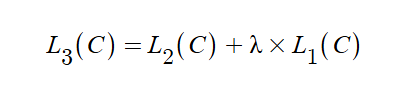

In [7]:
import time
import json
from pathlib import Path

import torch
import torch.nn as nn
from torch.nn.parallel import DistributedDataParallel
from torch.utils.tensorboard import SummaryWriter

def timeit(method):
    def timed(*args, **kw):
        _args = args[0].args

        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        if _args.distributed:
            if _args.local_rank == 0:
                print('Function Time: {}\t>\t{:.0f} min {:.0f} sec'.format(method.__name__, (te-ts)//60, (te-ts)%60))
        else:
            print('Function Time: {}\t>\t{:.0f} min {:.0f} sec'.format(method.__name__, (te-ts)//60, (te-ts)%60))

        return result
    return timed


## Trainer ##
class Trainer:
    def __init__(self, args, train_loader, test_loader, tokenizer):
        self.args = args
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size
        self.pad_id = tokenizer.pad_token_id
        self.eos_id = tokenizer.eos_token_id
        self.device = torch.device('cuda' if torch.cuda.is_available() and not args.no_cuda else 'cpu', args.local_rank)
        self.writer = SummaryWriter() if args.local_rank in [-1, 0] else None
        self.n_gpus = torch.distributed.get_world_size() if args.distributed else torch.cuda.device_count()
        assert args.pretrain != args.finetune
        # Do not set both finetune and pretrain arguments to the same (True, False)

        if args.pretrained_model:
            self.gpt = torch.load(args.pretrained_model)
        else:
            self.gpt = GPT(vocab_size=self.vocab_size,
                           seq_len=args.max_seq_len,
                           d_model=args.n_layers,
                           n_heads=args.n_attn_heads,
                           d_ff=args.fnn_hidden,
                           embd_pdrop=args.embd_dropout,
                           attn_pdrop=args.attn_dropout,
                           resid_pdrop=args.resid_dropout,
                           pad_id=self.pad_id)

        if args.pretrain:
            self.model = GPTLMHead(self.gpt)
        if args.finetune:
            with open(args.cached_label_dict, 'r') as file:
                label_dict = json.load(file)
            ## outputs에서 클래스 정보 예측하기 위해 문장 대표하는 한 벡터 추출 ##
            ## cls_token_id는 <EOS> 토큰으로 정의됨. ##
            ## 논문에서 말한 extract 토큰으로서 역할을 함. ##
            self.model = GPTClsHead(self.gpt, n_class=len(label_dict), cls_token_id=self.eos_id)
            self.model.to(self.device)

        if args.distributed:
            self.model = DistributedDataParallel(self.model, device_ids=[args.local_rank], output_device=args.local_rank)

        self.optimizer = RAdam(self.model.parameters(), args.lr)
        self.criterion = nn.CrossEntropyLoss(ignore_index=self.pad_id).to(self.device)
        self.cls_criterion = nn.CrossEntropyLoss().to(self.device)

    @timeit
    def train(self, epoch):
        if self.args.pretrain:
            self.pretrain(epoch)
        if self.args.finetune:
            self.finetune(epoch)

    def pretrain(self, epoch):
        losses = 0
        n_batches, n_samples = len(self.train_loader), len(self.train_loader.dataset)

        self.model.train()
        for i, batch in enumerate(self.train_loader):
            ## input 이용하여 target 만드는 과정 ##
            inputs = batch[0].to(self.device)
            targets = inputs[:, 1:].contiguous()
            # |inputs| : (batch_size, seq_len), |targets| : (batch_size, seq_len-1)

            lm_logits = self.model(inputs)
            lm_logits = lm_logits[:, :-1].contiguous()
            # |lm_logits| : (batch_size, seq_len-1, vocab_size)

            loss = self.criterion(lm_logits.view(-1, self.vocab_size), targets.view(-1))
            losses += loss.item()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if self.args.local_rank in [-1, 0]:
                self.writer.add_scalar('Loss/pre-train', loss.item(), ((epoch-1)*n_batches)+i)
                if i % (n_batches//5) == 0 and i != 0:
                    print('Iteration {} ({}/{})\tLoss: {:.4f}'.format(i, i, n_batches, losses/i))

        print('Train Epoch {} [rank: {}]\t>\tLoss: {:.4f}'.format(epoch, self.args.local_rank, losses/n_batches))

    def finetune(self, epoch):
        losses, accs = 0, 0
        n_batches, n_samples = len(self.train_loader), len(self.train_loader.dataset) # n_batches = batch size per GPU

        self.model.train()
        for i, batch in enumerate(self.train_loader):
            ## 위에 수식을 코드로 구현한 부분 ##
            inputs, labels = map(lambda x: x.to(self.device), batch)
            # |inputs| : (batch_size, seq_len), |labels| : (batch_size)

            lm_logits, cls_logits = self.model(inputs)
            lm_logits = lm_logits[:, :-1].contiguous()
            # |lm_logits| : (batch_size, seq_len-1, vocab_size), |cls_logits| : (batch_size, n_class)

            lm_loss = self.criterion(lm_logits.view(-1, self.vocab_size), inputs[:, 1:].contiguous().view(-1))
            cls_loss = self.cls_criterion(cls_logits, labels)
            loss = cls_loss + (self.args.auxiliary_ratio * lm_loss)

            losses += loss.item()
            acc = (cls_logits.argmax(dim=-1) == labels).to(dtype=cls_logits.dtype).mean()
            accs += acc

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if self.args.local_rank in [-1, 0]:
                self.writer.add_scalar('Loss/fine-tune', loss.item(), ((epoch-1)*n_batches)+i)
                self.writer.add_scalar('Accuracy/fine-tune', acc, ((epoch-1)*n_batches)+i)
                if i % (n_batches//5) == 0 and i != 0:
                    print('Iteration {} ({}/{})\tLoss: {:.4f} Acc: {:.1f}%'.format(i, i, n_batches, losses/i, accs/i*100.))

        print('Train Epoch {} [rank: {}]\t>\tLoss: {:.4f} / Acc: {:.1f}%'.format(epoch, self.args.local_rank, losses/n_batches, accs/n_batches*100.))

    def evaluate(self, epoch):
        losses, accs = 0, 0
        n_batches, n_samples = len(self.test_loader), len(self.test_loader.dataset)

        self.model.eval()
        with torch.no_grad():
            for i, batch in enumerate(self.test_loader):
                if self.args.pretrain:
                    inputs = batch.to(self.device)
                    targets = inputs[:, 1:].contiguous()

                    lm_logits = self.model(inputs)
                    lm_logits = lm_logits[:, :-1].contiguous()

                    loss = self.criterion(lm_logits.view(-1, self.vocab_size), targets.view(-1))
                    losses += loss.item()

                    if self.args.local_rank in [-1, 0]:
                        self.writer.add_scalar('Loss/pre-train(eval)', loss.item(), ((epoch-1)*n_batches)+i)

                elif self.args.finetune:
                    inputs, labels = map(lambda x: x.to(self.device), batch)

                    lm_logits, cls_logits = self.model(inputs)
                    lm_logits = lm_logits[:, :-1].contiguous()

                    lm_loss = self.criterion(lm_logits.view(-1, self.vocab_size), inputs[:, 1:].contiguous().view(-1))
                    cls_loss = self.cls_criterion(cls_logits, labels)
                    loss = cls_loss + (self.args.auxiliary_ratio * lm_loss)

                    losses += loss.item()
                    acc = (cls_logits.argmax(dim=-1) == labels).to(dtype=cls_logits.dtype).mean()
                    accs += acc

                    if self.args.local_rank in [-1, 0]:
                        self.writer.add_scalar('Loss/fine-tune(eval)', loss.item(), ((epoch-1)*n_batches)+i)
                        self.writer.add_scalar('Accuracy/fine-tune(eval)', acc, ((epoch-1)*n_batches)+i)

        print('Eval Epoch {} [rank: {}]\t>\tLoss: {:.4f} / Acc: {:.1f}%'.format(epoch, self.args.local_rank, losses/n_batches, accs/n_batches*100.))

    def save(self, epoch, model_prefix='model', root='.model'):
        path = Path(root) / (model_prefix + '.ep%d' % epoch)
        if not path.parent.exists():
            path.parent.mkdir()

        if self.args.distributed:
            if self.args.local_rank == 0:
                torch.save(self.gpt, path)
        else:
            torch.save(self.gpt, path)